In [1]:
# STEP 1: Upload Kaggle credentials
from google.colab import files
uploaded = files.upload()  # Upload your kaggle.json

import os, zipfile
json_filename = list(uploaded.keys())[0]
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
print(f"✅ Using Kaggle credential: {json_filename}")

# STEP 2: Download Plant Village Dataset
!kaggle datasets download -d emmarex/plantdisease
!unzip -qo plantdisease.zip -d PlantVillageData

Saving kaggle.json to kaggle.json
✅ Using Kaggle credential: kaggle.json
Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 99% 652M/658M [00:02<00:00, 272MB/s]
100% 658M/658M [00:02<00:00, 333MB/s]


In [2]:
# STEP 3: Reorganize data into train/val/test split
import shutil, random
base_dir = "PlantVillageData/PlantVillage"
output_dirs = ['train', 'val', 'test']
for dir_name in output_dirs:
    shutil.rmtree(dir_name, ignore_errors=True)

all_classes = os.listdir(base_dir)
for cls in all_classes:
    imgs = os.listdir(os.path.join(base_dir, cls))
    random.shuffle(imgs)
    n = len(imgs)
    train_n, val_n = int(0.8 * n), int(0.1 * n)

    for split, img_range in zip(output_dirs, [imgs[:train_n], imgs[train_n:train_n+val_n], imgs[train_n+val_n:]]):
        cls_dir = os.path.join(split, cls)
        os.makedirs(cls_dir, exist_ok=True)
        for img in img_range:
            shutil.copy(os.path.join(base_dir, cls, img), os.path.join(cls_dir, img))

In [3]:
# STEP 4: Data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('train', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
val_generator = val_test_datagen.flow_from_directory('val', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = val_test_datagen.flow_from_directory('test', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')

num_classes = len(train_generator.class_indices)
class_labels = list(train_generator.class_indices.keys())

Found 16504 images belonging to 15 classes.
Found 2058 images belonging to 15 classes.
Found 2076 images belonging to 15 classes.


In [4]:
# STEP 5: Define ViT Model
!pip install -q transformers
from transformers import TFAutoModel
import tensorflow as tf
from tensorflow.keras import layers, Model

class ViTLayer(layers.Layer):
    def __init__(self):
        super(ViTLayer, self).__init__()
        self.vit = TFAutoModel.from_pretrained('google/vit-base-patch16-224')
        self.vit.trainable = False

    def call(self, inputs):
        inputs = tf.transpose(inputs, [0, 3, 1, 2])
        return self.vit(pixel_values=inputs).last_hidden_state

def create_vit_model(num_classes):
    inputs = layers.Input(shape=(224, 224, 3))
    vit_outputs = ViTLayer()(inputs)
    pooled = layers.GlobalAveragePooling1D()(vit_outputs)
    x = layers.Dense(512, activation='relu')(pooled)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

model = create_vit_model(num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_layer (ViTLayer)           │ (None, 197, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 768)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401,423 (1.53 MB)

 Trainable params: 401,423 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# STEP 6: Train Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3)

start_time = time.time()
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, lr_scheduler]
)
training_time = time.time() - start_time

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 341s 590ms/step - accuracy: 0.7041 - loss: 0.9113 - val_accuracy: 0.8970 - val_loss: 0.2955 - learning_rate: 0.0010
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 286s 554ms/step - accuracy: 0.9011 - loss: 0.2938 - val_accuracy: 0.9388 - val_loss: 0.1787 - learning_rate: 0.0010
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 284s 551ms/step - accuracy: 0.9220 - loss: 0.2278 - val_accuracy: 0.9339 - val_loss: 0.1877 - learning_rate: 0.0010
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 287s 555ms/step - accuracy: 0.9296 - loss: 0.1988 - val_accuracy: 0.9276 - val_loss: 0.2081 - learning_rate: 0.0010
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 283s 549ms/step - accuracy: 0.9407 - loss: 0.1782 - val_accuracy: 0.9543 - val_loss: 0.1362 - learning_rate: 0.0010
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 281s 545ms/step - accuracy: 0.9378 - loss: 0.1762 - val_accuracy: 0.9534 - val_loss: 0.1417 - learning_rate: 0.0010
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 282s 546ms/step - accura

65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 417ms/step - accuracy: 0.9489 - loss: 0.1422


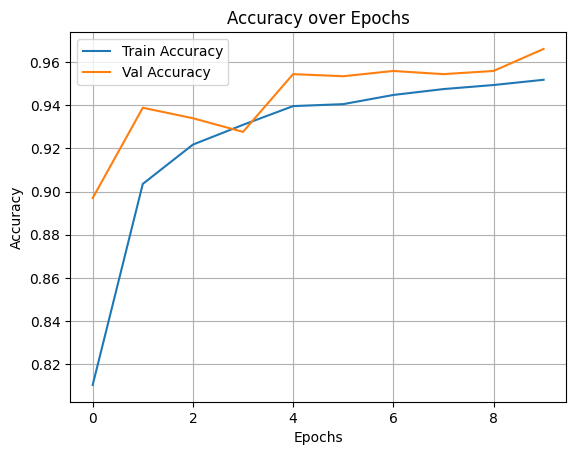

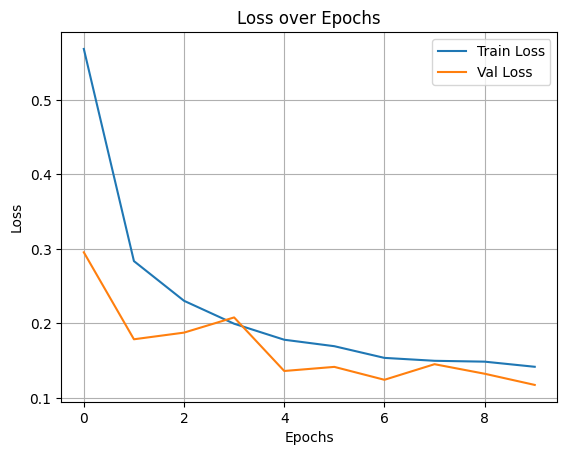

In [6]:
# STEP 7: Evaluation
import matplotlib.pyplot as plt
test_loss, test_accuracy = model.evaluate(test_generator)

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# STEP 8: Metrics Summary
import numpy as np
model_size = np.sum([np.prod(v.shape) for v in model.trainable_variables])
model_size_MB = model_size * 4 / (1024 ** 2)

print(f"\n✅ Training Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"✅ Validation Accuracy: {history.history['val_accuracy'][-1] * 100:.2f}%")
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"⏱️ Training Time: {training_time:.2f} seconds")
print(f"📦 Model Size: {model_size_MB:.2f} MB")


✅ Training Accuracy: 95.17%
✅ Validation Accuracy: 96.60%
✅ Test Accuracy: 95.81%
⏱️ Training Time: 2888.83 seconds
📦 Model Size: 1.53 MB


65/65 ━━━━━━━━━━━━━━━━━━━━ 33s 459ms/step

📊 Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.06      0.06      0.06       101
                     Pepper__bell___healthy       0.07      0.07      0.07       149
                      Potato___Early_blight       0.06      0.06      0.06       100
                       Potato___Late_blight       0.05      0.05      0.05       100
                           Potato___healthy       0.00      0.00      0.00        16
                      Tomato_Bacterial_spot       0.12      0.12      0.12       214
                        Tomato_Early_blight       0.02      0.02      0.02       100
                         Tomato_Late_blight       0.10      0.10      0.10       192
                           Tomato_Leaf_Mold       0.04      0.04      0.04        96
                  Tomato_Septoria_leaf_spot       0.08      0.08      0.08       

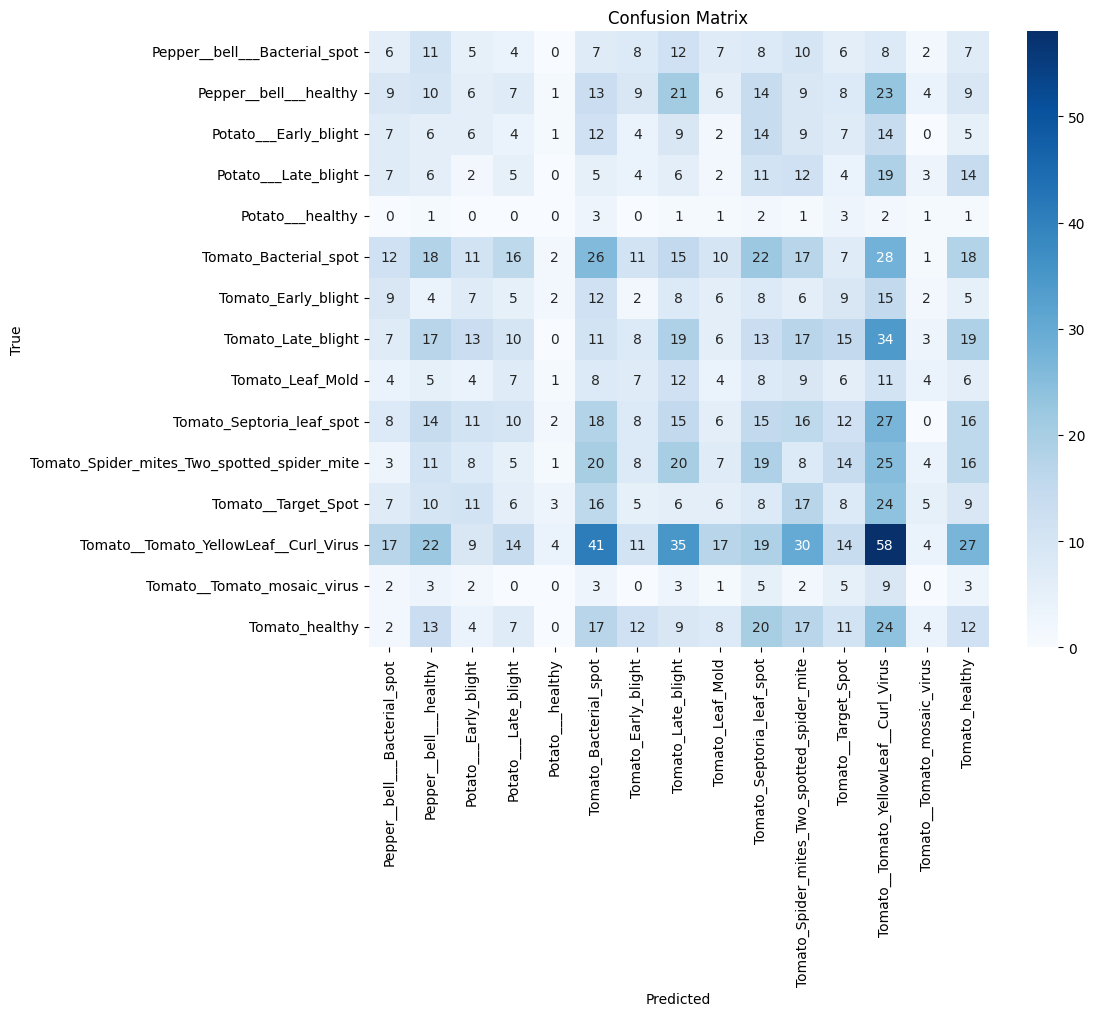

In [8]:
# STEP 9: Classification Report & Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

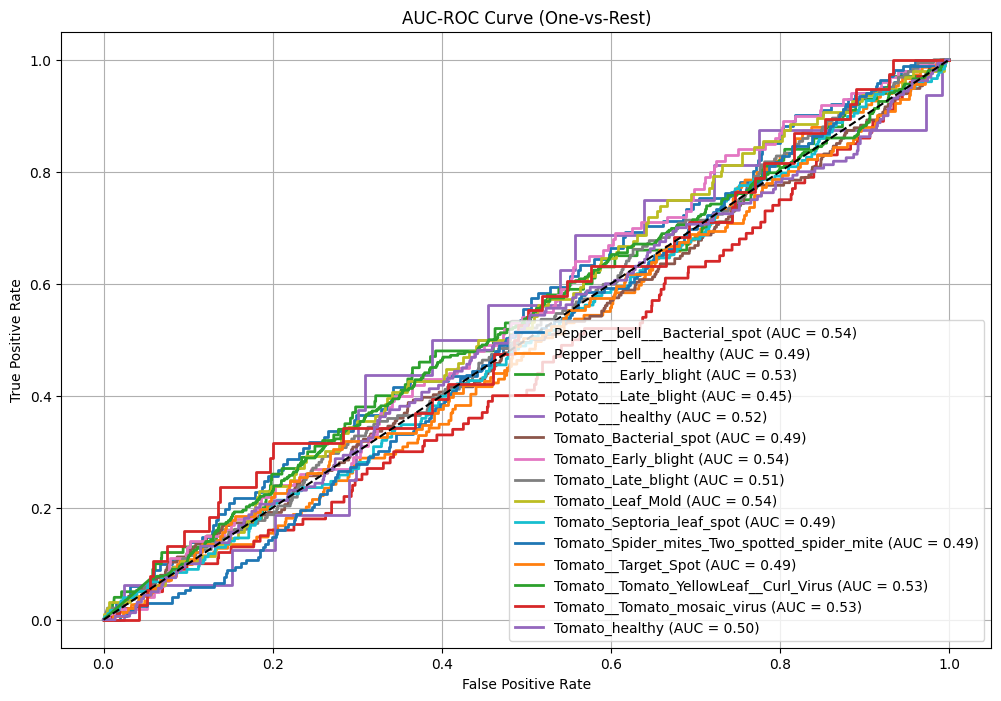

🧮 Macro-average AUC: 0.5088
🧮 Weighted-average AUC: 0.5064


In [9]:
# STEP 10: AUC-ROC
y_true_bin = label_binarize(y_true, classes=range(num_classes))
plt.figure(figsize=(12, 8))
for i, label in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("AUC-ROC Curve (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"🧮 Macro-average AUC: {roc_auc_score(y_true_bin, y_pred, average='macro'):.4f}")
print(f"🧮 Weighted-average AUC: {roc_auc_score(y_true_bin, y_pred, average='weighted'):.4f}")